<a href="https://colab.research.google.com/github/paulohenrique1303/Neural-Network/blob/main/Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [295]:
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
from sklearn import datasets

In [296]:
plt.rcParams['figure.figsize'] = (10,6)
plt.style.use('dark_background')

## Outros datasets

In [297]:
"""x , y = datasets.make_moons(n_samples= qtd_dados, noise= noise)
print(f'{x.shape = }\n{y.shape = }')"""

"x , y = datasets.make_moons(n_samples= qtd_dados, noise= noise)\nprint(f'{x.shape = }\n{y.shape = }')"

In [298]:
"""x, y = datasets.make_circles(n_samples=qtd_dados, noise=noise, factor=0.5)
print(f'{x.shape = }\n{y.shape = }')"""

"x, y = datasets.make_circles(n_samples=qtd_dados, noise=noise, factor=0.5)\nprint(f'{x.shape = }\n{y.shape = }')"

## Dataset

In [299]:
qtd_dados = 5000
noise = 2.5

In [300]:
x, y = datasets.make_blobs(n_samples=qtd_dados, centers=3, n_features=2, cluster_std=noise, random_state=42)
print(f'{x.shape = }\n{y.shape = }')

x.shape = (5000, 2)
y.shape = (5000,)


In [301]:
qtd_treino = int(0.8 * qtd_dados)
qtd_teste = int(0.2 * qtd_dados)
qtd_treino, qtd_teste

(4000, 1000)

In [302]:
x_train = x[:qtd_treino]
y_train = y[:qtd_treino]
x_test = x[qtd_treino:]
y_test = y[qtd_treino:]
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4000, 2), (4000,), (1000, 2), (1000,))

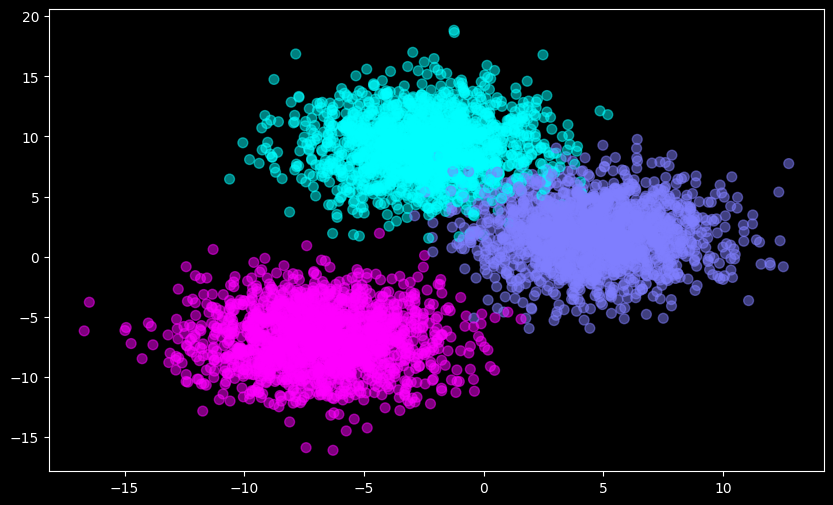

In [303]:
plt.scatter(x[:,0], x[:,1], c= y, s= 50, alpha = 0.5, cmap = 'cool' )

# Perceptron


In [304]:
class Perceptron:
    def __init__(self, input_size, learning_rate = 0.01, epochs= 1000):
        self.weights= np.zeros(input_size + 1)
        self.learning_rate= learning_rate
        self.epochs = epochs

    def train(self, X, y):
        for epochs in range(self.epochs):
            for i in range(len(X)):
                prediction = self.predict(X[i])
                error = y[i] - prediction

                self.weights[1:] += self.learning_rate * error * X[i]
                self.weigths[0] += self.learning_rate * error

    def predict(self, x):
        z = np.dot(x, self.weights[1:]) + self.weigths[0]

        return 1 if z > 0 else 0

In [305]:
class NeuralNetwork:
    def __init__(self, x: np.ndarray, y: np.ndarray, hidden_neurons: int= 3, output: int= 2):

        np.random.seed(69)

        self.x = x
        self.y = y
        self.hidden_neurons = hidden_neurons
        self.output = output
        self.input_neurons = self.x.shape[1]

        # Inicializando os pesos e bias.
        # Xavier Inicialization para garantir a variança dos pesos em todas as camadas.

        self.W1 = np.random.randn(self.input_neurons, self.hidden_neurons) / np.sqrt(self.input_neurons)
        self.B1 = np.zeros((1, self.hidden_neurons))
        self.W2 = np.random.randn(self.hidden_neurons, self.output) / np.sqrt(self.hidden_neurons)
        self.B2 = np.zeros((1, self.output))

        self.dict = {'W1': self.W1,
                     'B1': self.B1,
                     'W2': self.W2,
                     'B2': self.B2}

        self.z1 = 0
        self.f1 = 0
    def foward(self, x: np.ndarray):
        # Equação da reta
        # z1 = W1 * x + B1
        self.z1 = np.dot(x, self.W1) + self.B1

        # Primeira função de ativação
        # Vou utilizar a tangente hiperbolica
        self.f1 = np.tanh(self.z1)

        # Segunda equação da reta
        z2 = np.dot(self.f1, self.W2) + self.B2

        # Por ultimo vamos definar a função de ativação dos neuronios de saída
        # Como temos um problema de classificação multiclasse, vou etsar usando a softmax
        exp_scores = np.exp(z2)
        softmax = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return softmax

    def loss(self, softmax: np.ndarray):
        #Como o problema é de classificação multiclasse vou estar utilizamdo como função de perda Cross Entropy
        predictions = np.zeros(self.y.shape[0])
        for i, correct_index in enumerate(self.y):
            predicted = softmax[i][correct_index]
            predictions[i] = predicted

        log_prob = -np.log(predicted)
        return log_prob / self.y.shape[0]

    def backpropagation(self, softmax: np.ndarray, learning_rate: float) -> None:
        #Copia da softmax para não alterar o valor da variável original
        delta2 = np.copy(softmax)

        # Subtrai 1 da posição correspondente à classe correta nos resultados da softmax
        # Isso equivale ao cálculo do gradiente do erro da função de perda cross-entropy com softmax
        delta2[range(self.x.shape[0]), self.y] -= 1

        # Calcula o gradiente dos pesos da segunda camada (camada de saída)
        dW2 = np.dot(self.f1.T, delta2)  # f1 é a saída da primeira camada (camada oculta)

        # Calcula o gradiente dos vieses da segunda camada
        dB2 = np.sum(delta2, axis=0, keepdims=True)

        # Calcula o erro propagado para a camada anterior (camada oculta)
        # Multiplica pelo derivado da função de ativação
        delta1 = np.dot(delta2, self.W2.T) * (1 - np.power(self.f1, 2))

        # Gradiente dos pesos da primeira camada (entrada para camada oculta)
        dW1 = np.dot(self.x.T, delta1)

        # Gradiente dos vieses da primeira camada
        dB1 = np.sum(delta1, axis=0, keepdims=True)

        # Atualização dos pesos e baias com base nos gradientes e na taxa de aprendizado
        self.W1 -= learning_rate * dW1
        self.B1 -= learning_rate * dB1
        self.W2 -= learning_rate * dW2
        self.B2 -= learning_rate * dB2


    def fit(self, epochs: int, learning_rate: float) -> np.ndarray:
        for epoch in range(epochs):
            softmax = self.foward(self.x)
            loss = self.loss(softmax)
            self.backpropagation(softmax, learning_rate)

            #Acurácia
            predictions = np.argmax(softmax, axis=1)
            correct = (predictions == self.y).sum()
            accuracy = correct / self.y.shape[0]

            if int((epoch + 1) % (epochs / 10)) == 0: #imprime na tela os dados de 10 epocas,
                print(f'Epoch: {epoch + 1} / {epochs}, Accuracy: {accuracy:.3f}, Loss: {loss.item():.4f}')

        return predictions

    def predict(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        softmax = self.foward(x)
        #Acurácia
        predictions = np.argmax(softmax, axis=1)
        correct = (predictions == y).sum()
        accuracy = correct / y.shape[0]
        print(f'Accuracy: {accuracy:.3f}')
        return predictions

    def save(self, path: str) -> None:
        with open(path, 'wb') as file:
            pickle.dump(self.dict, file)

# Modelo

In [306]:
hidden_neurons = 10
output_neurons = 3
epochs = 100
learning_rate = 0.01

In [307]:
model = NeuralNetwork(x_train, y_train, hidden_neurons, output_neurons)
previsoes_treinamento = model.fit(epochs, learning_rate)

Epoch: 10 / 100, Accuracy: 0.949, Loss: 0.0000
Epoch: 20 / 100, Accuracy: 0.970, Loss: 0.0000
Epoch: 30 / 100, Accuracy: 0.971, Loss: -0.0000
Epoch: 40 / 100, Accuracy: 0.972, Loss: 0.0000
Epoch: 50 / 100, Accuracy: 0.896, Loss: 0.0101
Epoch: 60 / 100, Accuracy: 0.973, Loss: -0.0000
Epoch: 70 / 100, Accuracy: 0.970, Loss: -0.0000
Epoch: 80 / 100, Accuracy: 0.974, Loss: -0.0000
Epoch: 90 / 100, Accuracy: 0.806, Loss: -0.0000
Epoch: 100 / 100, Accuracy: 0.971, Loss: -0.0000


Text(0.5, 1.0, 'Treinamento')

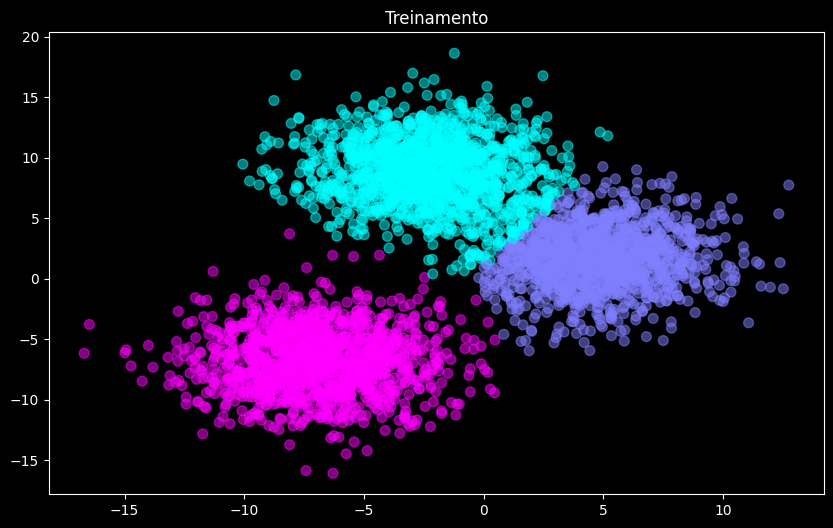

In [308]:
plt.scatter(x_train[:,0], x_train[:,1], c= previsoes_treinamento, s= 50, alpha = 0.5, cmap = 'cool' )
plt.title('Treinamento')

In [309]:
 previssoes_teste = model.predict(x_test, y_test)

Accuracy: 0.965


Text(0.5, 1.0, 'Teste')

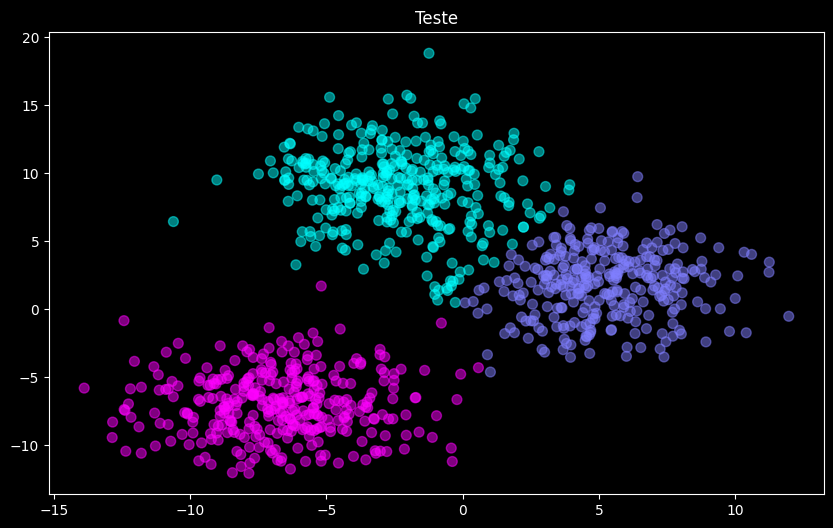

In [310]:
plt.scatter(x_test[:,0], x_test[:,1], c= previssoes_teste, s= 50, alpha = 0.5, cmap = 'cool' )
plt.title('Teste')

Text(0.5, 1.0, 'Real')

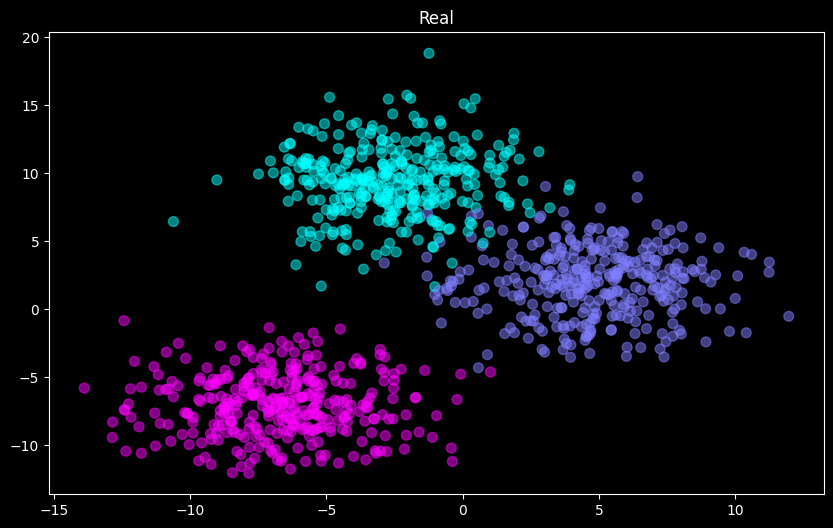

In [311]:
plt.scatter(x_test[:,0], x_test[:,1], c= y_test, s= 50, alpha = 0.5, cmap = 'cool' )
plt.title('Real')

In [312]:
model.save('model.pkl')